# Tutorial 06: Quantum Phase Estimation algorithms

In [1]:
import numpy as np
from qiskit import *
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Part 1: Quantum Phase Estimation

As a reminder, the goal of quantum phase estimation is to determine the phase $\theta \in [0,1)$ applied by a unitary operator $U$ on its eigenstate $\vert\psi\rangle$ such that

$$U\vert\psi\rangle = e^{2\pi i\theta}\vert\psi\rangle \; .$$

Since $\theta \in [0,1)$, it can be approximately represented by binary fractions on $n$ bits as 

$$(. \theta_{n-1} \theta_{n-2}...\theta_1 \theta_0) \equiv \frac{\theta_{n-1}}{2} + \frac{\theta_{n-2}}{2^2} + ... + \frac{\theta_{1}}{2^{n-1}} + \frac{\theta_{0}}{2^n} \; . $$

QPE uses two qubit registers: one register with $L$ qubits to encode $|\psi\rangle$, and one register with $t$ qubits (often called "measurement" or "counting qubits") to encode $\theta$.

As discussed in the lecture, $t$ is determined according to the accuracy we impose on $\theta$, and to the probaility of error $\epsilon$ that we allow.

The QPE algorithm consists of four main steps:

1. State Initialization: we create a superposition of all $2^t$ computational basis states on the $t$ measurement qubits by applying a Hadamard ($H$) gate on each qubit starting off in the state $\vert0\rangle^{\otimes t}$. We also initialize the $L$ target qubits to an eigenstate $\vert\psi\rangle$ of the unitary operator $U$. 

2. We apply the unitary operator $U$ with various powers onto the $L$ target qubits controlled by the measurement qubits. 

3. We apply an inverse quantum Fourier transform on the $t$ measurement qubits.

4. Finally, we measure the $t$ qubits and read out $2^t\theta$ (with some success probability $1-\epsilon$ if $\theta$ cannot be exactly expressed with $t$ bits).

The circuit diagram looks like this (note that this diagram uses Qiskit's qubit ordering convention) (you need to download the figure "circuit_QPE.png" from the lernraum so it appears here): 

<img src="circuit_QPE.png">

## Step A. Implementation of the QPE circuit for a one-qubit operator $U$

Here we will consider the simple case where $L=1$ and where the unitary operator $U$ is given by

$$U = \begin{bmatrix}1 & 0\\ 0 & e^{2\pi i\theta}\end{bmatrix}$$

for which an eigenstate is the single-qubit state $|\psi\rangle=\vert1\rangle$: 

$$U\vert1\rangle = e^{2\pi i\theta}\vert1\rangle$$

Our objective is to determine $\theta$ using quantum phase estimation. 

<h4 style="font-size: 17px">&#128211; Build the corresponding QPE circuit </h4>

You will need:

1.  `Qiskit`'s controlled-$P$ gate `cp(phi, control, target)`. The matrix for the $P$ gate is

$$P = \begin{bmatrix}1 & 0\\ 0 & e^{i\phi}\end{bmatrix}$$ 

The first argument is the angle $\phi = 2\pi\theta$, the second the number of the control qubit, and the third argument is the number of the target qubit.

2. `Qiskit`'s circuit library already has a quantum fourier transform implemented: you can import it with the command  `from qiskit.circuit.library import QFT`. Alternatively you can build your own QFT circuit.

3. The inverse of a circuit `circ` can be implemented using the command `circ.inverse()`

In [2]:
from qiskit.circuit.library import QFT

Fill the cell below to create a function that takes in the two arguments `t` (number of measurement qubits) and `theta` (angle $\theta$), and returns the corresponding QPE circuit.

In [3]:
pi = np.pi

def qpe_program(t, theta):
    
    ############### your code goes here
    qc = QuantumCircuit(t+1,t)
    for i in range(t):
        qc.h(i)
    qc.x(t)
    phi = 2*pi*theta
    for i in range(t):
        for j in range(2**i):
            qc.cp(phi, i, t)
    qc.append(QFT(t, inverse=True, do_swaps=True), range(t))
    # qc.inverse()
    for i in range(t):
        qc.measure(i, i)
    # qc.draw(output='mpl')
    ###############
    return qc

# Step B: QPE simulation for $\theta = 1/4$

<h4 style="font-size: 17px">&#128211; How many qubits $t$ do you need to express $\theta=1/4$? </h4>

<h4 style="font-size: 17px">&#128211; Run your circuit on the `AerSimulator()` classical simulator and check that the result corresponds to the bit-string representation of $\theta$ </h4>


In [4]:
def binary_to_fraction(counts,t):
    theta_est = np.array([round(int(key, 2)/2**t,3) for key in list(counts.keys())])
    key_new = list(map(str, theta_est))
    count_new = dict(zip(key_new, counts.values()))
    display(plot_histogram(count_new, figsize=(18,4)))
    return

#binary_to_fraction(counts,t)

In [5]:
from qiskit_aer import StatevectorSimulator
backend = StatevectorSimulator()

{'01000000': 10}


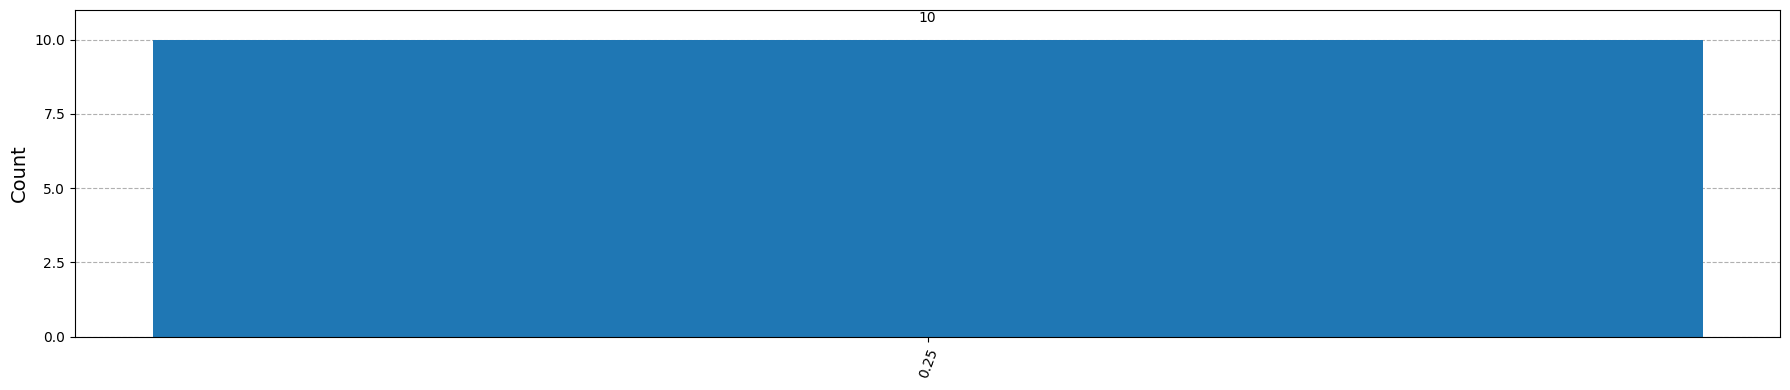

In [6]:
############### your code goes here
t=8
circuit = qpe_program(t,1/4)
circuit.draw(output='mpl')
compiled_circuit = transpile(circuit, backend)
job = backend.run(compiled_circuit, shots=10)
result = job.result()
# outputstate = result.get_statevector(circuit, decimals=8)
outputcount = result.get_counts(circuit)
# print(outputstate)
print(outputcount)
binary_to_fraction(outputcount,t)
###############

In [7]:
############### your code goes here
# circuit.draw(output='mpl')

# Step C: QPE simulation for $\theta = 1/3$

<h4 style="font-size: 17px">&#128211; Repeat the previous steps for $\theta=1/3$ and vary the number of bits $t$ to increase the precision of your results. </h4>

Because $\theta = 1/3$ cannot be expressed in a finite number of bits, you will now obtain a probability distribution of outcomes, and thus must use more than one shot.

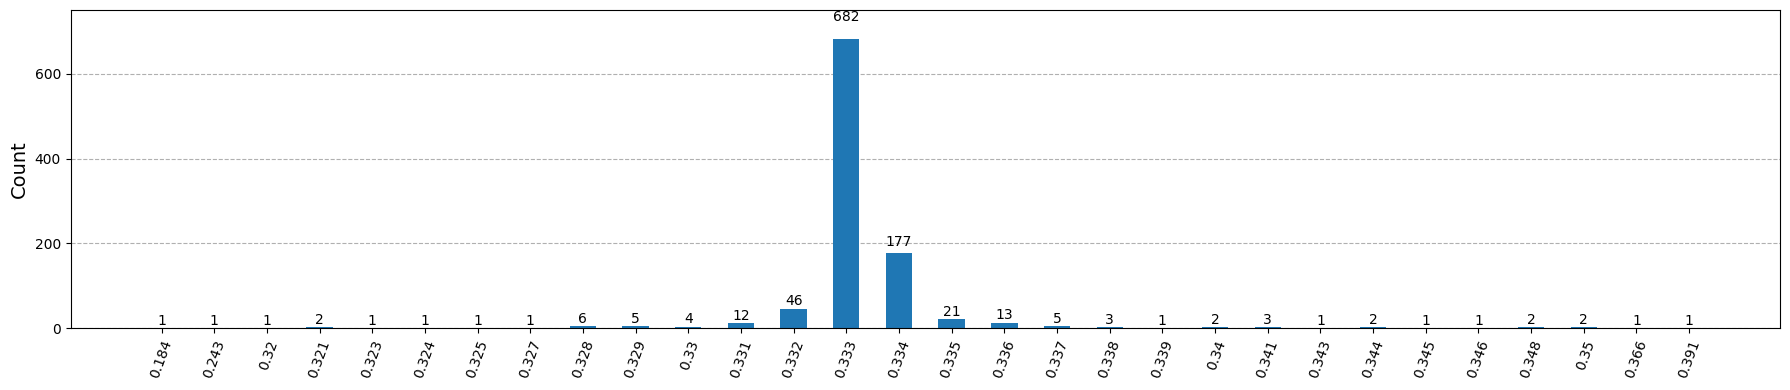

In [8]:
############### your code goes here
t=10
circuit = qpe_program(t,1/3)
circuit.draw(output='mpl')
compiled_circuit = transpile(circuit, backend)
job = backend.run(compiled_circuit, shots=1000)
result = job.result()
# outputstate = result.get_statevector(circuit, decimals=8)
counts = result.get_counts(circuit)
binary_to_fraction(counts,t)
# result_array = []
# a = [0,1,0,1,0,1,0,1,1]
# for i in range(len(a)):
#     result_array.append(a[i]/2**((i+1)))
# result_array = np.array(result_array)
# print(np.sum(result_array))
###############

You can use the function below which takes the results of the experiment ('job.result().get_count()'), converts the bit strings to binary fractions and replots the same histogram with the corresponding estimated $\theta$ values on the x-axis.

# PART 2: Iterative Phase Estimation

The QPE algorithm requires a number of counting qubits $t$ that scales with the desired accuracy for $\theta$, and necessitates a large number of CNOT gates, which are the dominant source of error when running a circuit. As discussed in the lecture, the Iterative Phase Estimation (IPE) algorithm is an alternative to QPE, which requires only one single auxiliary qubit and evaluates the phase through a repetitive process. In this case, the accuracy of the algorithm is restricted by the number of iterations rather than the number of counting qubits. Therefore, IPE circuits are of practical interest for near-term quantum computing (noisy quantum computers).



We will address the same problem as above with IPE to determine $\theta$ to accuracy $2^{-n}$.

We therefore need a system of two qubits, $q_0$ and $q_1$, where $q_0$ is auxiliary qubit and the qubit $q_1$ represents the physical system on which $U$ operates. Having them initialized as $q_0 \rightarrow |+\rangle$ and $q_1 \rightarrow |\Psi \rangle$, application of control-U between $q_0$ and $q_1$ $2^j$ times would change the state of $q_0$ to $|0\rangle + e^{i 2 \pi 2^{j} \theta} | 1 \rangle$. That is, the phase of $U$ has been kicked back into $q_0$ as many times as the control operation has been performed.

For example, 

for $j=0$, the phase encoded into $q_0$ would be $e^{i 2 \pi 2^{0} \theta} = e^{i 2 \pi \theta} = e^{i 2 \pi (.\theta_{n-1} \theta_{n-2} ... \theta_0)}$


for $j=1$, the phase would be $e^{i 2 \pi 2^{1} \theta} = e^{i 2 \pi \theta_{n-1}} e^{i 2 \pi (.\theta_{n-2} \theta_{n-3}... \theta_0)} = e^{i 2 \pi (.\theta_{n-2} \theta_{n-3}... \theta_0)}$ 

for $j=2$, it would be $e^{i 2 \pi 2^{2} \theta} = e^{i 2 \pi 2 \theta_{n-1}} e^{i 2 \pi \theta_{n-2}} e^{i 2 \pi (.\theta_{n-3} \theta_{n-4} ... \theta_0)} = e^{i 2 \pi (.\theta_{n-3} \theta_{n-4} ... \theta_0)}$

and so on...

for $j=n-2$, $e^{i 2 \pi 2^{n-2} \theta} =  e^{i 2 \pi (.\theta_1 \theta_0)} = e^{i 2 \pi \left( \frac{\theta_1}{2} + \frac{\theta_0}{4} \right)} $. 

for $j=n-1$, $e^{i 2 \pi 2^{n-1} \theta} =  e^{i 2 \pi (. \theta_0)} = e^{i \pi \theta_0} $. 

We see that for the last case with $j=n-1$, the state of $q_0$ is $|0\rangle + e^{i \pi \theta_0}|1\rangle$ which is the state $|+\rangle$ if $\theta_0 = 0$ and $|-\rangle$ if $\theta_0 = 1$. If we then apply a Hadamard gate and measure in the computational basis, we would thus get outcome $|0\rangle$ and $|1\rangle$ respectively. 


As discussed in the lecture,  the steps of the IPE algorithm are the following:

1. `First step`: Initialize the 2-qubit registers ( $q_0 \rightarrow |+\rangle$ and $q_1 \rightarrow |\Psi \rangle$ ), perform $2^{n-1}$ control-$U$ operations, apply H on $q_0$ and measure $q_0$. The outcome is directly the least significant bit $\theta_0$.

2. `Second step`: Initialize and apply $2^{n-2}$ control-$U$ operations. The relative phase in $q_0$ after these operations is now $e^{i 2 \pi (.\theta_1 \theta_0)} = e^{i 2 \pi \left( \frac{\theta_1}{2} + \frac{\theta_0}{4} \right)}$.
To extract the phase bit $\theta_{1}$, first perform a phase correction by rotating around the $z$-axis of angle $-2 \pi \theta_0/4=-\pi \theta_0/2$, which results in the state of  $q_0$ to be $|0\rangle + e^{i \pi \theta_1} | 1 \rangle$. Again we apply Hadamard and perform a measurement on $q_0$ to obtain the phase bit $\theta_{1}$. 

and so on... until the `$n$-th` step.

Therefore, in an arbitrary `$k$-th step` we initialize, apply control-$U$ $2^{n-k}$ times, rotate $q_0$ around $z$ by angle $\omega_k = - \pi (.\theta_{k-2} ... \theta_0)$, apply a Hadamard gate to $q_0$, and a measure it. The outcome is $\theta_{k-1}$.

Below we show the circuit for step $k$: (you need to download the figure "circuit_IPE.png" from the lernraum so it appears here)

<img src="circuit_IPE.png">

# IPE circuit implementation

 One advantage of IPE is that one can construct one circuit for each step $k$. For the purpose of demonstration, we will however encode all the steps in one single circuit using mid-circuit measurements and classically-controlled operations, as well as reset operations on the qubits.

You will need to use:
- the Qiskit `reset` to reset a qubit to state $|0\rangle$ (for example `circ.reset(q[0])` resets qubit #0 of qubit register q in circuit 'circ')
- controlled operations conditionned on the outcome of a mid-circuit measurement usch as `if_test`. For example, the commented cell below applies a Hadamard gate to qubit #i of qubit register "q" if the bit #j of classical register "c" is equal to 1.

In [9]:
#with qc.if_test((c[j], 1)):
#   qc.h(q[i])

<h4 style="font-size: 17px">&#128211; Preliminary: determine how you can apply the rotation $P(\phi_k)$ using mid-circuit measurements and classically conditionned controlled gates</h4>



<h4 style="font-size: 17px">&#128211; Define a function that constructs the full IPE circuit </h4>


In [49]:
def ipe_program(n, theta):  

    q = QuantumRegister(2)
    c = ClassicalRegister(n)
    qc = QuantumCircuit(q,c)

    ############### your code goes here
    for k in range(1,n):
        qc.h(q[0])
        qc.x(q[1])
        phi = 2*pi*theta
        qc.cp(-2**(n-k)*phi, control_qubit=0, target_qubit=1)
        # theta_k = []
        # for j in range(k-1):
        #     with qc.if_test((c[j],1)) as else_:
        #         theta_k.append(1/2**(k-2-j))
        #     with else_:
        #         theta_k.append(0)
        qc.h(0)
        qc.measure(0,n-k)
        qc.reset(0)
        qc.reset(1)
    ###############

    return qc

<h4 style="font-size: 17px">&#128211; Test your circuit for different values of $\theta$ and $n$, and compare to the QPE results </h4>


{'00010': 1000}


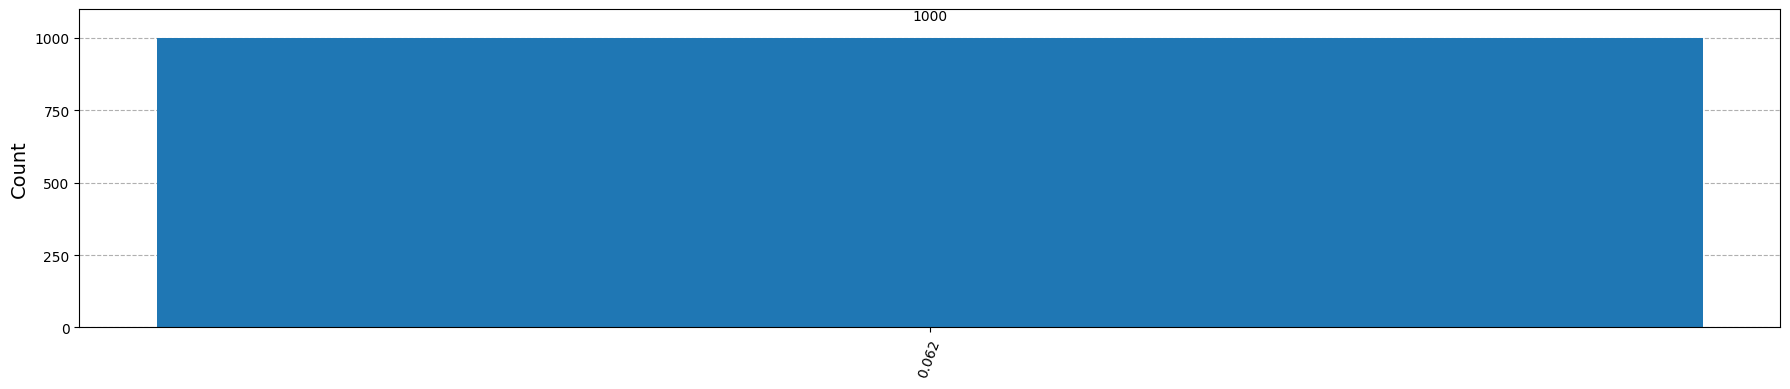

In [51]:
############### your code goes here
n = 5
theta = 1/4
circuit = ipe_program(n,theta)
# circuit.draw(output='mpl')
backend = AerSimulator()
compiled_circuit = transpile(circuit, backend)
job = backend.run(compiled_circuit, shots=1000)
result = job.result()
counts = result.get_counts(circuit)
print(counts)
binary_to_fraction(counts,n)
###############

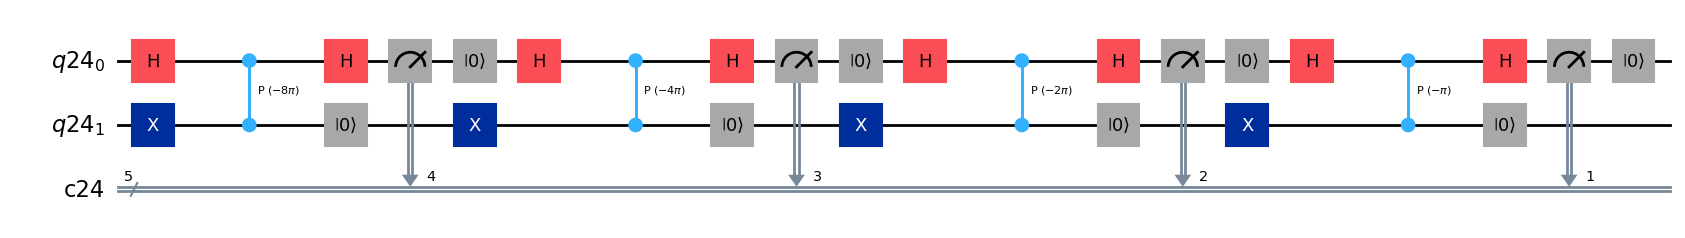

In [52]:
circuit.draw(output='mpl')

# Part 3: Comparison QPE/IPE in the presence of noise

To investigate the impact of the noise from real quantum system on the outcome, we will perform noisy simulations of IPE circuit employing a Qiskit `noise` module which produces a simplified noise model for an IBM quantum system.

<h4 style="font-size: 17px">We provide the example on how to use the noisy simulator for QPE: </h4>

depth=  50


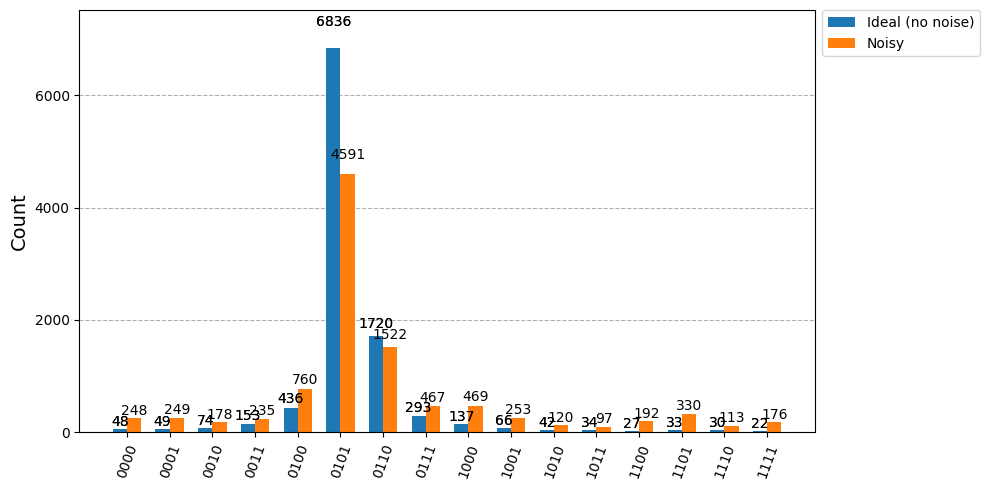

In [12]:
theta = 1/3
t = 4
n_shots = 10000

#### Repeat exact QPE for comparison:
qpe_ex = qpe_program(t, theta)
sim = AerSimulator()
trans_qpe_ex = transpile(qpe_ex, sim)
job = sim.run(trans_qpe_ex,shots=n_shots)
counts_ex = job.result().get_counts(trans_qpe_ex)

#### Noisy QPE:
# We will include a noise model that includes an error of 2% on every CX gate. 
# In practice, the error arising from the two-qubit gates, are the dominant source of error when running a circuit
from qiskit_aer.noise import NoiseModel, depolarizing_error
noise_model = NoiseModel()
err_proba = 0.03
noise_model.add_all_qubit_quantum_error(depolarizing_error(err_proba, 2), ["cx"])

noisy_sim = AerSimulator(noise_model=noise_model)
qpe = qpe_program(t, theta)
qpe_trans = transpile(qpe, noisy_sim)

print("depth= ",qpe_trans.depth())

job = noisy_sim.run(qpe_trans,shots=n_shots)
counts = job.result().get_counts(qpe_trans)

## plot both exact and noisy results:
plot_histogram([counts_ex,counts], figsize=(10,5), legend=['Ideal (no noise)', 'Noisy'])


<h4 style="font-size: 17px">&#128211; Apply the same noise model to IPE and compare to your previous results.  </h4>

depth=  36


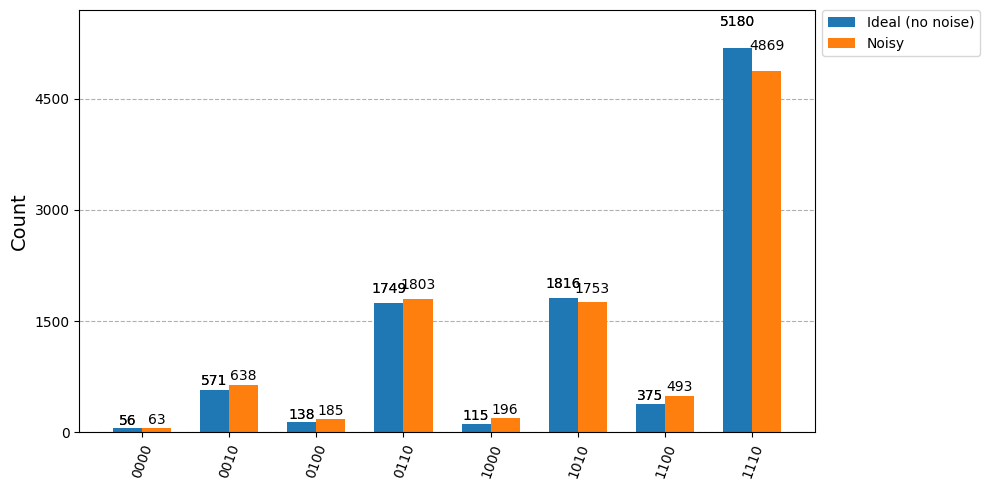

In [13]:
############### your code goes here
theta = 1/3
t = 4
n_shots = 10000

#### Repeat exact QPE for comparison:
qpe_ex = ipe_program(t, theta)
sim = AerSimulator()
trans_qpe_ex = transpile(qpe_ex, sim)
job = sim.run(trans_qpe_ex,shots=n_shots)
counts_ex = job.result().get_counts(trans_qpe_ex)

#### Noisy QPE:
# We will include a noise model that includes an error of 2% on every CX gate. 
# In practice, the error arising from the two-qubit gates, are the dominant source of error when running a circuit
from qiskit_aer.noise import NoiseModel, depolarizing_error
noise_model = NoiseModel()
err_proba = 0.03
noise_model.add_all_qubit_quantum_error(depolarizing_error(err_proba, 2), ["cx"])

noisy_sim = AerSimulator(noise_model=noise_model)
qpe = ipe_program(t, theta)
qpe_trans = transpile(qpe, noisy_sim)

print("depth= ",qpe_trans.depth())

job = noisy_sim.run(qpe_trans,shots=n_shots)
counts = job.result().get_counts(qpe_trans)

## plot both exact and noisy results:
plot_histogram([counts_ex,counts], figsize=(10,5), legend=['Ideal (no noise)', 'Noisy'])
###############

<h4 style="font-size: 17px">&#128211; Discuss in class the sensitivity of IPE and QPE circuits to noise </h4>